# Analysis of scRNA-seq data

In [124]:
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt

In [125]:
adata = sc.read_h5ad(
    '../processed/scRNAseq_featureCounts_NumReads.h5ad'
)
adata

AnnData object with n_obs × n_vars = 348 × 54456
    obs: 'sample_description', 'sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID'
    var: 'Length'

In [126]:
adata.obs['nCount_RNA'] = np.array(adata.X.sum(axis = 1)).flatten()
adata.obs['nFeature_RNA'] = np.array((adata.X > 0).sum(axis = 1)).flatten()
adata.obs['percent_mt'] = \
    np.array(adata[:, adata.var.index.str.startswith('mt')].X.sum(axis = 1)).flatten() / \
    np.array(adata.X.sum(axis = 1)).flatten()
adata.obs['percent_ribo'] = \
    np.array(adata[:, adata.var.index.str.match('^Rp[sl]')].X.sum(axis = 1)).flatten() / \
    np.array(adata.X.sum(axis = 1)).flatten()

In [127]:
adata.obs.groupby('sample_mouseID').count()

,sample_description,sample_genotype,sample_treatment,sample_sex,sample_litter,nCount_RNA,nFeature_RNA,percent_mt,percent_ribo
sample_mouseID,,,,,,,,,
GN21/475,67,67,67,67,67,67,67,67,67
GNF1/464,37,37,37,37,37,37,37,37,37
GNF1/469,50,50,50,50,50,50,50,50,50
GNF1/473,64,64,64,64,64,64,64,64,64
GNF1/480,65,65,65,65,65,65,65,65,65
GNF1/483,61,61,61,61,61,61,61,61,61


In [128]:
#removing mouse litter G1/55 A
adata = adata[~(adata.obs.sample_litter == 'G1/55 A'), :].copy()
adata

AnnData object with n_obs × n_vars = 222 × 54456
    obs: 'sample_description', 'sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'percent_ribo'
    var: 'Length'

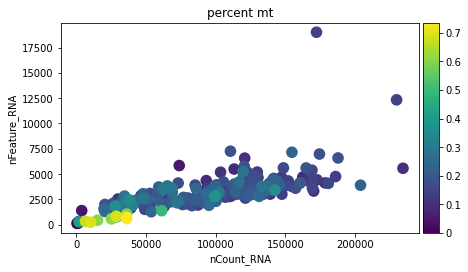

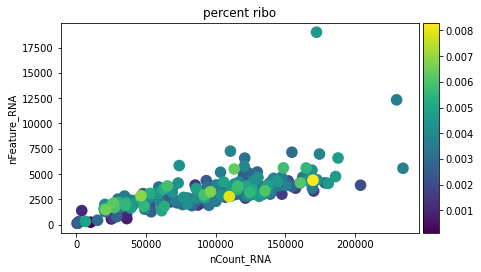

In [129]:
ax = sc.pl.scatter(
    adata, 
    'nCount_RNA', 
    'nFeature_RNA',
    show = False,
    color = 'percent_mt'
)
ax = sc.pl.scatter(
    adata, 
    'nCount_RNA', 
    'nFeature_RNA',
    show = False,
    color = 'percent_ribo'
)

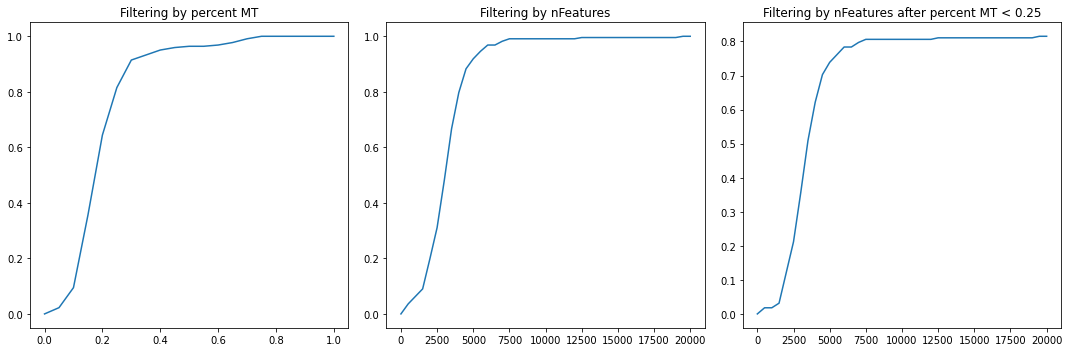

In [130]:
# Filtering cells
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
x1 = np.linspace(0, 1, 21)
data1 = [(adata.obs.percent_mt < i).sum()/len(adata.obs) for i in x1]
ax1.plot(x1, data1)
ax1.set_title('Filtering by percent MT')

x2 = np.linspace(0, 20000, 41)
data2 = [(adata.obs.nFeature_RNA < i).sum()/len(adata.obs) for i in x2]
ax2.plot(x2, data2)
ax2.set_title('Filtering by nFeatures')

data3 = [(adata[adata.obs.percent_mt < 0.25].obs.nFeature_RNA < i).sum()/len(adata.obs) for i in x2]
ax3.plot(x2, data3)
ax3.set_title('Filtering by nFeatures after percent MT < 0.25')

fig.set_figwidth(15)
fig.set_figheight(5)
fig.tight_layout()

In [133]:
adata = adata[(adata.obs.nFeature_RNA > 1500) & (adata.obs.percent_mt < 0.3), :].copy()
adata

AnnData object with n_obs × n_vars = 195 × 54456
    obs: 'sample_description', 'sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'percent_ribo'
    var: 'Length'

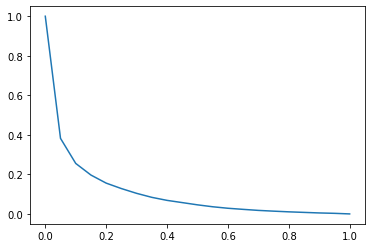

In [134]:
# Filtering genes
sc.pp.filter_genes(adata, min_counts = 5)

fig, ax = plt.subplots()
x = np.linspace(0, 1, 21)
expressed = np.array((adata.X > 0).sum(axis = 0)).flatten()/len(adata.obs)
data = [(expressed > i).sum()/len(expressed) for i in x]
ax.plot(x, data)

In [138]:
adata = adata[:, ~adata.var.index.str.match('^Rp[sl]') & ~adata.var.index.str.startswith('mt') & (np.array((adata.X > 0).sum(axis = 0)).flatten() > 5)].copy()
adata

AnnData object with n_obs × n_vars = 195 × 17300
    obs: 'sample_description', 'sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'percent_ribo'
    var: 'Length', 'n_counts'

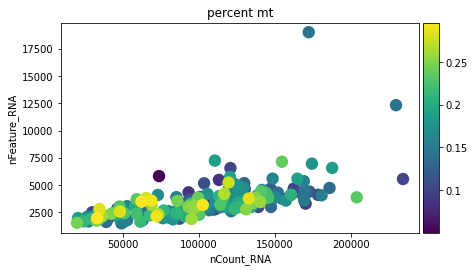

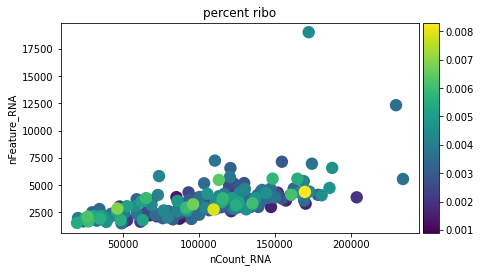

In [139]:
ax = sc.pl.scatter(
    adata, 
    'nCount_RNA', 
    'nFeature_RNA',
    show = False,
    color = 'percent_mt'
)
ax = sc.pl.scatter(
    adata, 
    'nCount_RNA', 
    'nFeature_RNA',
    show = False,
    color = 'percent_ribo'
)

In [140]:
adata.write_h5ad(
    '../processed/scRNAseq_featureCounts_NumReads.filtered.h5ad'
)

In [141]:
def normalize_tpm(adata, scale = 1e4):
    X = adata.X.toarray().T / adata.var.Length.values[:, None] * 1000
    factors = X.sum(axis = 0) * scale
    return X.T / factors[:, None]

adata = sc.read_h5ad(
    '../processed/scRNAseq_featureCounts_NumReads.filtered.h5ad'
)
adata.layers['counts'] = adata.X.copy()
adata.layers['tpm'] = normalize_tpm(adata)
adata.X = adata.layers['tpm']
adata

AnnData object with n_obs × n_vars = 195 × 17300
    obs: 'sample_description', 'sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'percent_ribo'
    var: 'Length', 'n_counts'
    layers: 'counts', 'tpm'

In [142]:
#basically seurat preprocessing
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [143]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1500,
    layer = 'counts',
    flavor = 'seurat_v3'
)

In [144]:
sc.pp.pca(
    adata, 
    n_comps = 40, 
    svd_solver = 'arpack',
    use_highly_variable = True,
)
sc.pp.neighbors(
    adata,
    n_neighbors = 5,
    knn = True
)
sc.tl.umap(adata)

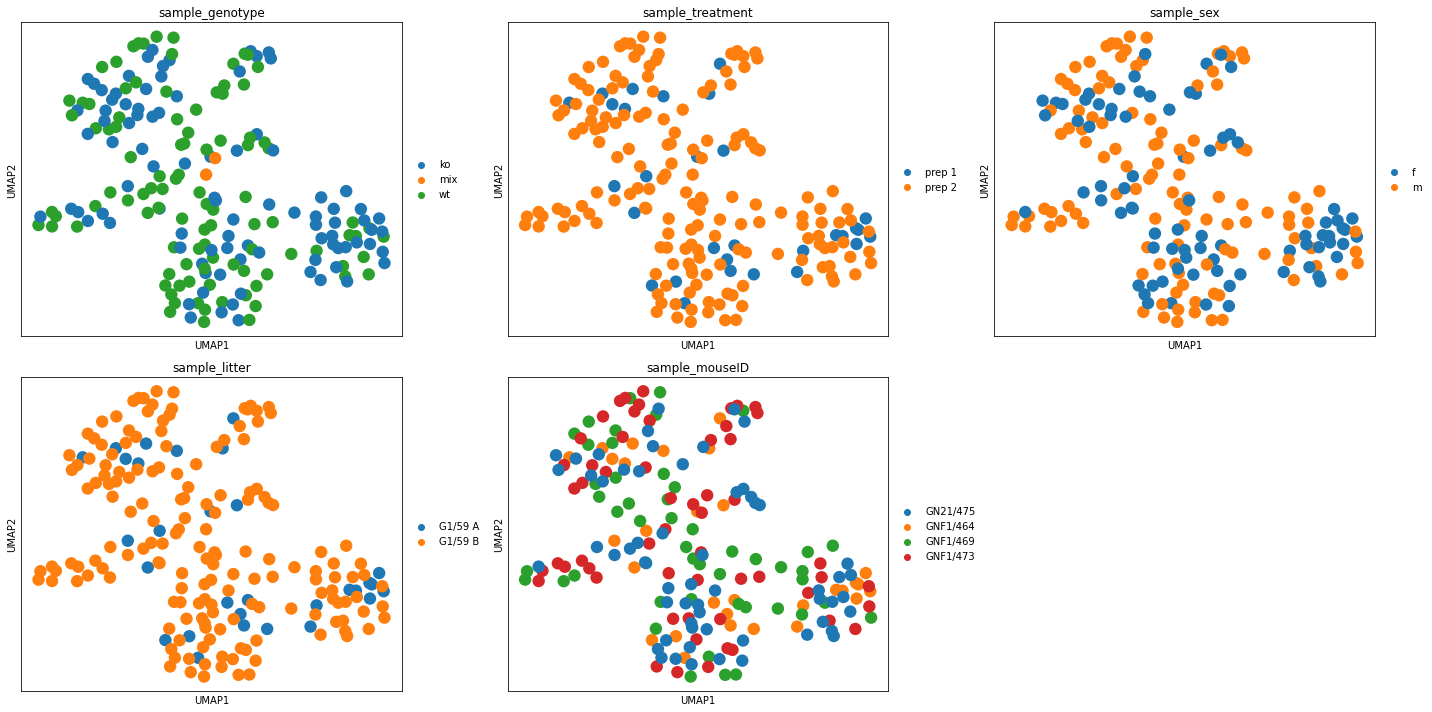

In [145]:
fig, axs = plt.subplots(2, 3)
keys = ['sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID']
for key, ax in zip(keys, axs.reshape(6)):
    sc.pl.umap(
        adata,
        color = key,
        show = False,
        ax = ax
    )

axs[-1, -1].remove()
fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()

In [146]:
import scvi
scvi.model.SCVI.setup_anndata(
    adata,
    layer = 'counts',
   # continuous_covariate_keys = ['percent_mt', 'percent_ribo']
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 195 cells, 17300 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [147]:
model = scvi.model.SCVI(adata)

In [148]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Set SLURM handle signals.


Epoch 400/400: 100%|██████████| 400/400 [04:33<00:00,  1.46it/s, loss=1.51e+04, v_num=1]


In [149]:
adata.obsm['X_scvi'] = model.get_latent_representation()

In [150]:
adata.layers["scvi"] = model.get_normalized_expression(
    library_size=10e4
)

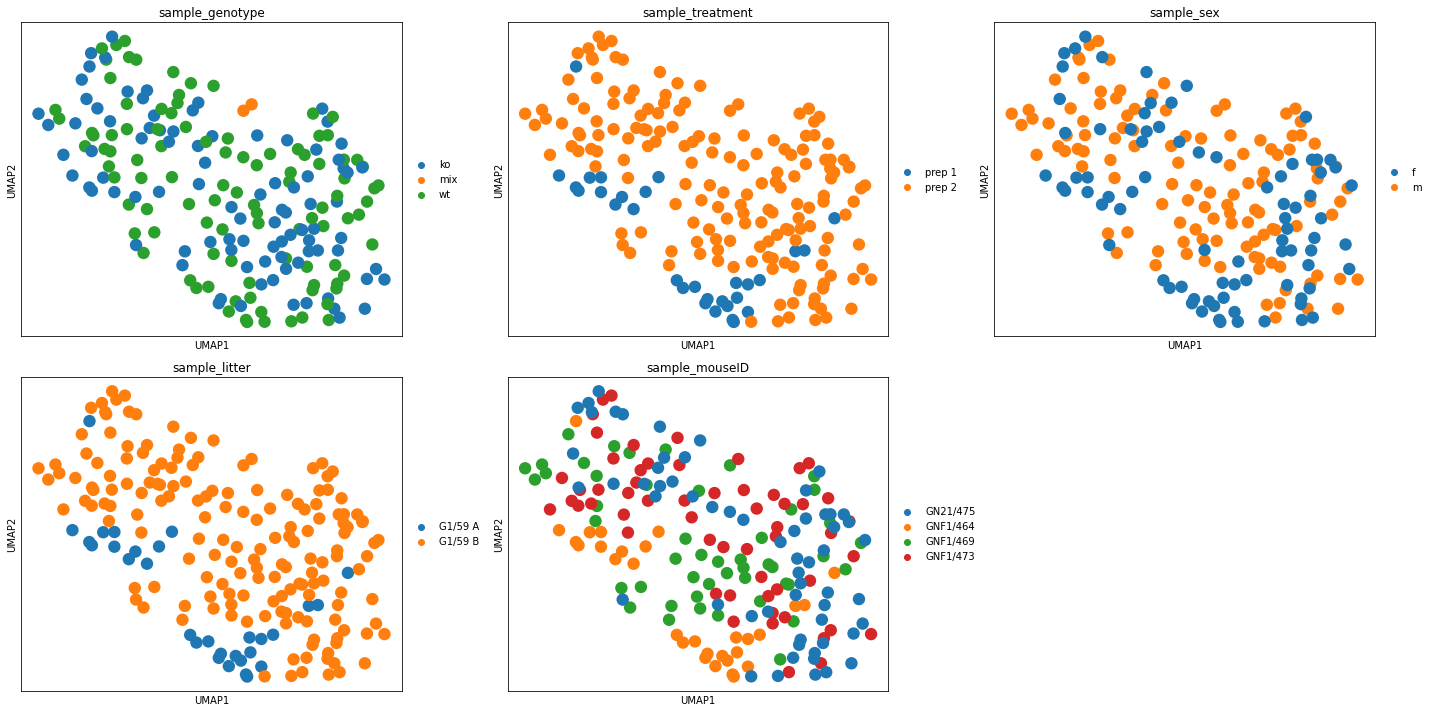

In [151]:
sc.pp.neighbors(
    adata, 
    use_rep="X_scvi",
    n_neighbors = 5,
    knn = True
)
sc.tl.umap(adata)
fig, axs = plt.subplots(2, 3)
keys = ['sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID']
for key, ax in zip(keys, axs.reshape(6)):
    sc.pl.umap(
        adata,
        color = key,
        show = False,
        ax = ax
    )

axs[-1, -1].remove()
fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()